# Análise e tratamento da base de dados

In [1]:
from scipy.io import arff

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [2]:
data = arff.loadarff('data/emotions.arff')
df = pd.DataFrame(data[0])

### Remoção de dados inválidos

Primeiramente, faremos a limpeza dos dados faltosos e de duplicatas

In [3]:
df = df.dropna(how ='any')
df = df.drop_duplicates()

### Correlação

A fim de reduzir a dimensionalidade do problema, vamos observar se há a presença de dados correlacionados

In [4]:
corr_matrix = df.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

Como se pode observar, há, de fato, colunas com alta correlação. Iremos eliminá-las

In [5]:
corr_matrix = corr_matrix.abs()

# Triangulo superior da matriz de correlação
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 

# Escolhendo as colunas com correlação >80%
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]  

# Excluindo tais colunas
df.drop(df[to_drop], axis = 1, inplace=True)

### Transformação dos dados

A fim de não tratar esse problema como um multi label, realizaremos a binarização dos dados por meio da função abaixo, que considerará cada classe como uma potência de 2, e por fim somará tudo.\
Por exemplo a classe amazed-suprised será 2⁰, happy-pleased 2¹ e assim por diante.

In [6]:
def binarize(original):
    binary = pd.DataFrame()
    for i in range(len(original.columns)):
        if not i:
            binary = pd.DataFrame(original.iloc[:,i:i+1].values.astype(int)) * 2**i
        else:
            binary += original.iloc[:,i:i+1].values.astype(int) * 2**i
    return binary

Podemos, então, aplicar a função às classes.

In [7]:
num_classes = 6
classes = df.iloc[:,len(df.columns) - num_classes : len(df.columns)]

# Classes binarizadas
classes_binary = binarize(classes)
classes_binary

,0
0,6
1,33
2,34
3,4
4,8
...,...
588,28
589,49
590,28
591,6


Com isso feito, podemos remover o conjunto de classes de nosso DataFrame, e inserir a nova coluna binarizada 'emotions'.

In [8]:
df.drop(classes, inplace = True, axis = 1)
df = df.join(classes_binary).rename(columns = {0:'emotions'})

### Balanceamento dos dados

Vamos plotar um gráfico para visualizar de maneira mais clara como se dá a distribuição das classes em nossa base de dados.

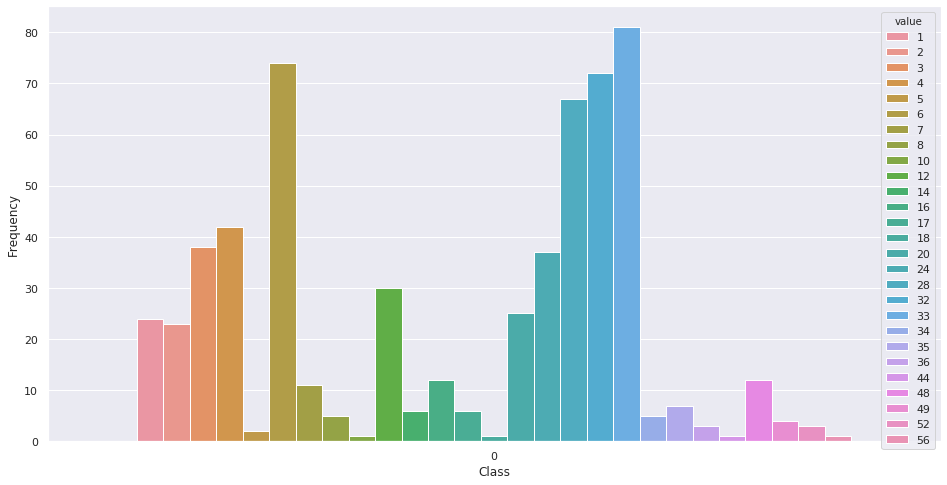

In [9]:
plt.figure(figsize = (16,8))
sns.set(style="darkgrid")
sns.countplot(x="variable", hue="value", data = pd.melt(classes_binary))
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

Como se pode ver, há uma enorme diferença na frequência das classes, com algumas tendo mais de 80 representações, e outras menos de 10! Para resolver isso, iremos remover classes com um número muito baixo de amostras, nesse caso, estaremos considerando abaixo de 5. Após isso, faremos um oversample, visando evitar que nossos modelos se superajustem às classes majoritárias.

In [10]:
# Pegando o número de amostras de cada classe
num_samples = classes_binary[0].value_counts()

# Pegando os índices das amostras de classes com menos de 5 amostras
few_samples = num_samples.loc[num_samples < 5].index

# Removendo cada uma delas de nosso DataFrame
for sample in few_samples:
    to_drop = df.loc[df['emotions'] == sample].index
    df = df.drop(index = to_drop[0])

Com isso feito, já podemos separar nossos atributos de nossas classes.

In [11]:
# Classes
y = df['emotions'].values 

del df['emotions']

# Atributos
X = df.values 

Agora, só resta aplicar o oversample.

In [12]:
ros = RandomOverSampler()
X, y = ros.fit_resample(X, y)

Checando se está tudo como esperado.

In [13]:
pd.Series(y).value_counts()

52    81
16    81
2     81
3     81
4     81
5     81
6     81
7     81
8     81
12    81
14    81
17    81
49    81
20    81
24    81
28    81
32    81
33    81
34    81
35    81
36    81
48    81
1     81
dtype: int64

### Normalização

Para a máquina não supervalorizar os valores mais altos, é interessante fazermos a normalização dos atributos

In [14]:
sc = skp.StandardScaler()
X = sc.fit_transform(X)

### Separação dos conjuntos de treino e teste

E dividindo o conjunto treino e teste:

In [15]:
X_train ,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

Agora, temos tudos em mãos para treinar nossos modelos >:)

# Approach 1: Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Métricas
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

Criando nosso classificador K Nearest Neighbors.

In [17]:
dt = DecisionTreeClassifier()

Treinando-o.

In [18]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

E botando pra rodar.

In [19]:
y_pred_dt = dt.predict(X_test)

Faremos a discussão das métricas de nossa predição na seção de resultados.

# Approach 2: Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

Criando nosso classificador Random Forest.

In [21]:
rf = RandomForestClassifier(n_jobs=-1)

Treinando-o.

In [22]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

E botando pra rodar.

In [23]:
y_pred_rf = rf.predict(X_test)

Faremos a discussão das métricas de nossa predição na seção de resultados.

# Resultados

### Decision Tree

In [24]:
print(confusion_matrix(y_test,y_pred_dt))
print("\nAcurácia =", accuracy_score(y_test, y_pred_dt))
print("Precisão =", precision_score(y_test, y_pred_dt, average='weighted'))
print("Sensibilidade =", recall_score(y_test, y_pred_dt, average='weighted'))
print("F1 =", f1_score(y_test, y_pred_dt, average='weighted'))

[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1 13  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  2  0]
 [ 0  0  0 12  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  3  0  6  2  0  0  0  1  0  0  1  0  1  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  0 14  6  0  0  0  0  0  0

### Random Forest

In [25]:
print(confusion_matrix(y_test,y_pred_rf))
print("\nAcurácia =", accuracy_score(y_test, y_pred_rf))
print("Precisão =", precision_score(y_test, y_pred_rf, average='weighted'))
print("Sensibilidade =", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1 =", f1_score(y_test, y_pred_rf, average='weighted'))

[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  2  0  0  0  0  0  0  0  0  0  2  2  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  9  0  0  3  0  0  0  0  0  1  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0 16  4  0  0  0  0  0  0

Primeiramente, podemos ver através de matrix de confusão que nossos modelos aparentemente estão operando bem, uma vez que a diagonal da matriz, que indica um acerto, está concentrando a maior parte das predições. E isso é confirmado pelas métricas obtidas.
- A acurácia simplesmente indica a porcentagem dos acertos feitos pelo modelo.
- A precisão, intuitivamente, é a habilidade do modelo não classificar uma amostra negativa como positiva, ou seja, com um menor número de falsos positivos.
- A sensibilidade é a habilidade do modelo de encontrar todos as amostras postivas, de forma a reduzir os falsos negativos.
- A F1 é uma métrica que leva em consideração tanto a precisão como a sensibilidade.

Ao observar os resultados, podemos concluir que os modelos alcançaram resultados desejados, com o Random Forest a frente da Decision Tree, o que era esperado, considerando que o Random Forest é uma variante de maior complexidade da própria Decision Tree.\
Dessa forma, pode-se afirmar que os modelo são generalizados, sendo ajustados ao nossos dados e ainda evitando superajustes aos conjuntos de treino.

# Bônus

### Decision Tree

Mudando os parâmetros:
- 'splitter' de 'best' para 'random'
- 'criterion' de 'gini' para 'entropy'

In [26]:
dt = DecisionTreeClassifier(splitter='random', criterion='entropy')

Treinando-o.

In [27]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

E botando pra rodar.

In [28]:
y_pred_dt = dt.predict(X_test)

In [29]:
print(confusion_matrix(y_test,y_pred_dt))
print("\nAcurácia =", accuracy_score(y_test, y_pred_dt))
print("Precisão =", precision_score(y_test, y_pred_dt, average='weighted'))
print("Sensibilidade =", recall_score(y_test, y_pred_dt, average='weighted'))
print("F1 =", f1_score(y_test, y_pred_dt, average='weighted'))

[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  2  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0  1]
 [ 0  0  0 11  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  6  0  0  3  0  0  0  0  3  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 13  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0  0  0  0 15  3  2  0  0  0  0  0

Podemos notar uma pequena queda nas em nossas métricas de avaliação, muito provavelmente pela alteração do critério de divisão ter sido trocado, já que ao invés de sempre pegar a melhor divisão, será sorteado uma das melhores, o que levará por vezes à divisão "menos" melhor.

### Random Forest

In [38]:
rf = RandomForestClassifier(n_estimators=10, criterion='entropy', n_jobs=-1)

Treinando-o.

In [39]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

E botando pra rodar.

In [40]:
y_pred_rf = rf.predict(X_test)

In [41]:
print(confusion_matrix(y_test,y_pred_rf))
print("\nAcurácia =", accuracy_score(y_test, y_pred_rf))
print("Precisão =", precision_score(y_test, y_pred_rf, average='weighted'))
print("Sensibilidade =", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1 =", f1_score(y_test, y_pred_rf, average='weighted'))

[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  1  0  0  0  0  0  0  0  0  0  3  1  0  0  0  0  0  0]
 [ 0  0  0 11  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  0  9  0  0  1  0  0  0  2  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0 16  5  0  0  0  0  0  0

Novamente, conseguimos perceber uma pequena queda em nossas métricas, mas agora, provávelmente se dá ao fato de termos uma quantidade muito pequena de árvores em nossa floresta, o que levará à modelagens mais simples, e consequentemente menos ajustadas aos dados.